# About the approach 

The first thought to deal with the problem was to go with the LSTMs and deep learning,
but the considering the time required by deep learning models to train, another approach was required. Also the text contained a lot of words not available in public word embeddings 
and training the word embeddings is also time consuming
The technique I used consisted of the following steps:
1. **Tf-idf features:** Since the data is text, Tf-idf was good choice to generate features and 
   also these features in sparse form are very efficient to manage and use, also
   they an do not consume a lot of memory. Generated 1,00,000 features for each of heading and description
2. **Linear model was used:** Since the total feature was now about 2,00,000, the most time efficient models are the linear models. Boosted trees and 
   non linear models consume a lot of time to run.
3. **Ridge classifier was used** - Ridge was used since it reduces the complexity of the model by coefficient shrinkage,
   also help with regularization and trains faster.
4. **Time and Memory efficient:** The entire code runs in less than 10 mins, does not consume enough RAM and gives an accuracy of 92.2%.

**Connecting colab to google drive**



In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

** Importing the required dependencies **

In [0]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
import warnings

warnings.filterwarnings('ignore')

** Loading the data **

In [6]:
train = pd.read_csv("drive/ag_news_csv/train.csv", names = ["label","heading","description"])
test = pd.read_csv("drive/ag_news_csv/test.csv",names = ["label","heading","description"])
print(train.shape)
print(test.shape)

(120000, 3)
(7600, 3)


In [7]:
test.head(5)

,label,heading,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [8]:
train.head(5)

,label,heading,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


** Removing '\n' which was added for every newline and ("") which was added for every (") **

In [0]:
train["description"] = train["description"].replace('\n',' ').replace('""',' ')
test["description"] = test["description"].replace('\n',' ').replace('""',' ')

**Adding the following groups of features:**
    - Tf-Idf with news description (ngram_range=(1, 2), max_features=100000)
    - Tf-Idf with news heading (ngram_range=(1, 2), max_features=100000 )

In [11]:

%%time
tf = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_train_description_sparse = csr_matrix(tf.fit_transform(train["description"]))
print(X_train_description_sparse.shape)
X_test_description_sparse = csr_matrix(tf.transform(test["description"]))
print(X_test_description_sparse.shape)


(120000, 100000)
(7600, 100000)
CPU times: user 14 s, sys: 292 ms, total: 14.3 s
Wall time: 14.3 s


In [12]:
%%time
tf = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_train_heading_sparse = csr_matrix(tf.fit_transform(train["heading"]))
print(X_train_heading_sparse.shape)
X_test_heading_sparse = csr_matrix(tf.transform(test["heading"]))
print(X_test_heading_sparse.shape)


(120000, 100000)
(7600, 100000)
CPU times: user 3.98 s, sys: 77.8 ms, total: 4.06 s
Wall time: 4.06 s


In [13]:
# garbage collection
import gc
print(gc.collect())

406


**Join all sparse matrices.**

In [0]:
X_train_sparse = hstack([X_train_description_sparse, X_train_heading_sparse]).tocsr()

In [0]:
X_test_sparse = hstack([X_test_description_sparse, X_test_heading_sparse]).tocsr()

In [16]:
print(X_train_sparse.shape)
print(X_test_sparse.shape)

(120000, 200000)
(7600, 200000)


**Train a  Ridge model along with validation .**

In [18]:
%%time
y_train = train['label'].values
ridge = RidgeClassifier()
scores = cross_val_score(ridge, X_train_sparse, y_train, cv=5)
#ridge.fit(X_train_part_sparse, y_train_part);

CPU times: user 1min 55s, sys: 72.9 ms, total: 1min 55s
Wall time: 1min 55s


In [19]:
scores.mean()

0.9068833333333333

** Train the model on the entire dataset. **

In [20]:
%%time
ridge.fit(X_train_sparse, y_train);

CPU times: user 29.3 s, sys: 8.94 ms, total: 29.3 s
Wall time: 29.4 s


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

** Predict on the test set **

In [21]:
%%time
ridge_test_pred = ridge.predict(X_test_sparse)

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 14.4 ms


In [23]:
y_test = test["label"].values
print("Accuracy Score:  ", accuracy_score(ridge_test_pred, y_test))

Accuracy Score:   0.9223684210526316


In [24]:
print("Error Percentage:  ", (1-accuracy_score(ridge_test_pred, y_test))*100)

Error Percentage:   7.763157894736839


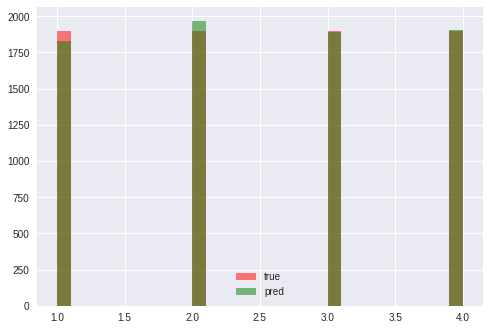

In [26]:
plt.hist(y_test, bins=30, alpha=.5, color='red', label='true');
plt.hist(ridge_test_pred, bins=30, alpha=.5, color='green', label='pred');
plt.legend();

** Classification Report **

In [27]:
target_names = ['World', 'Sports', 'Business', 'Sci/Tech']
print(classification_report(y_test, ridge_test_pred, target_names=target_names))

             precision    recall  f1-score   support

      World       0.94      0.91      0.92      1900
     Sports       0.95      0.98      0.97      1900
   Business       0.89      0.89      0.89      1900
   Sci/Tech       0.90      0.91      0.90      1900

avg / total       0.92      0.92      0.92      7600

